**Instalación y Carga del Modelo**

In [ ]:
# 1. Instalar Unsloth y dependencias BLINDADAS
%%capture
# Instalar Unsloth desde su repositorio oficial
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers<0.0.27" "trl<0.9.0" "peft==0.11.1" accelerate bitsandbytes

In [ ]:
# 2. Importar librerías y cargar el modelo base
from unsloth import FastLanguageModel
import torch

max_seq_length = 2048
dtype = None
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
# --- BLOQUE FALTANTE: CONFIGURACIÓN DE LoRA ---

# Convertimos el modelo base en un modelo PEFT (Trainable)
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Rango de atención (16 es estándar y eficiente)
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # 0 es más rápido
    bias = "none",    # "none" ahorra memoria
    use_gradient_checkpointing = "unsloth", # Truco para usar menos VRAM
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

print(" Adaptadores LoRA agregados. Ahora el modelo es entrenable.")

==((====))==  Unsloth 2025.12.7: Fast Llama patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.12.7 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


✅ Adaptadores LoRA agregados. Ahora el modelo es entrenable.


**Carga y Formateo de tus Datos**

In [ ]:
from datasets import load_dataset

# 4. Definir el formato del prompt (Estilo Alpaca)
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Token de fin de secuencia

def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Insertamos tus datos en la plantilla
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

# 5. Cargar tu archivo
# IMPORTANTE: Sube tu archivo 'algoritmos_train.jsonl' en la carpeta de la izquierda
dataset = load_dataset("json", data_files="dataset.jsonl", split="train")
dataset = dataset.map(formatting_prompts_func, batched = True)

**Ejecutar el Entrenamiento**

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 94 | Num Epochs = 10 | Total steps = 120
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040 of 8,072,204,288 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.737100
2,2.575000
3,2.671800
4,2.689900
5,2.669300
6,2.299000
7,2.334500
8,2.069000
9,2.046100
10,1.775300


Generando gráfica de entrenamiento...


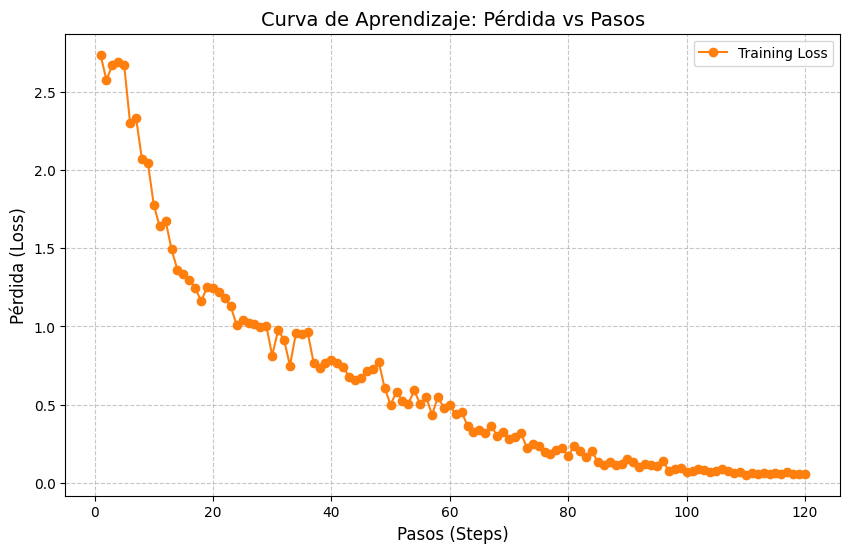

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments

# 6. Configurar el entrenador
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Puede ser True para acelerar si tienes muchos datos cortos
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 120,
        learning_rate = 1e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",
    ),
)

# 7. ¡Entrenar!
trainer_stats = trainer.train()

import matplotlib.pyplot as plt
import pandas as pd

# 1. Convertimos el historial de entrenamiento en un DataFrame
history = pd.DataFrame(trainer.state.log_history)

# 2. Filtramos para tener solo los pasos donde se registró la pérdida (loss)
if 'loss' in history.columns:
    # Quitamos filas que no tengan dato de loss (a veces guarda otros logs)
    loss_data = history[history['loss'].notna()]

    # 3. Creamos la gráfica
    plt.figure(figsize=(10, 6))
    plt.plot(loss_data['step'], loss_data['loss'], marker='o', color='#ff7f0e', label='Training Loss')

    # Decoración
    plt.title('Curva de Aprendizaje: Pérdida vs Pasos', fontsize=14)
    plt.xlabel('Pasos (Steps)', fontsize=12)
    plt.ylabel('Pérdida (Loss)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    print("Generando gráfica de entrenamiento...")
    plt.show()
else:
    print("No se encontraron datos de pérdida para graficar.")

**Guardar**

In [ ]:
# Guardar los adaptadores LoRA localmente en la máquina virtual
model.save_pretrained("tutor_algoritmos")
tokenizer.save_pretrained("tutor_algoritmos")
# Guardamos solo los cambios (esto ocupa muy poco espacio y memoria)
model.save_pretrained("mis_adaptadores_temporales")
tokenizer.save_pretrained("mis_adaptadores_temporales")
print("✅ Adaptadores guardados. Ahora es seguro reiniciar.")

✅ Adaptadores guardados. Ahora es seguro reiniciar.


**Probar el Tutor**

In [ ]:
# 8. Probar el modelo (Versión Avanzada)
FastLanguageModel.for_inference(model) # Habilitar modo inferencia (más rápido)

# Función para limpiar y mostrar la respuesta
def preguntar(pregunta):
    prompt = alpaca_prompt.format(pregunta, "", "")
    inputs = tokenizer([prompt], return_tensors = "pt").to("cuda")

    # Generamos la respuesta
    outputs = model.generate(**inputs, max_new_tokens = 300, use_cache = True)

    # Decodificamos y limpiamos el texto basura
    respuesta_sucia = tokenizer.batch_decode(outputs)[0]
    respuesta_limpia = respuesta_sucia.split("### Response:")[-1].replace(EOS_TOKEN, "").strip()

    print(f" PREGUNTA: {pregunta}")
    print(f" TUTOR:\n{respuesta_limpia}")
    print(f"{'-'*60}\n")

# --- TUS PRUEBAS ---

# Prueba 1: Analogía
preguntar("No entiendo por qué mi función recursiva nunca termina")

 PREGUNTA: No entiendo por qué mi función recursiva nunca termina
 TUTOR:
Una función recursiva es como mirarte en dos espejos enfrentados: la imagen se repite hasta el infinito.

Paso a paso:
1. Escribes el problema en términos de la solución más pequeña.
2. La llamada recursiva cambia el estado del problema.
3. Asegúrate de tener un **caso base** claro: una condición que detiene la recursividad.

Si el caso base falta, la función se llama a sí misma sin avanzar realmente, como un espejo sin retroalimentación.

Ejemplo simple: una función que calcula el factorial. En lugar de calcular todo, llama a sí misma con un parámetro menor. Esto genera una pila de llamadas que nunca se limpia.

Pensarlo en términos de pila ayudará a entender por qué funciones recursivas sin caso base pueden causar *stack overflow*.
------------------------------------------------------------



**Bajar archivo**

In [ ]:
# Guardar en formato GGUF (8bit o 4bit quant) para usar en tu PC con 6GB VRAM
# Esto tardará unos minutos en convertir
model.save_pretrained_gguf("tutor_algoritmos_gguf", tokenizer, quantization_method = "q4_k_m")

# Moverlo a Drive para bajarlo luego
shutil.copy("tutor_algoritmos_gguf/unsloth.Q4_K_M.gguf", "/content/drive/MyDrive/tutor_algoritmos_v1.gguf")
print("¡Archivo GGUF listo en Drive! Este sí corre en tu GTX de 6GB.")